In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

unidf=pd.read_csv(r"C:\Users\hajar\Time-Series-Crime-Forecasting-Minneapolis-3\data\Univ_Date.csv")

## SARIMA
1. Split the data into a train and test using time-based splitting
2. Check Assumptions and make corrections if needed
3. Select ARIMA Model
4. Select Best ARIMA Model
4. Interpret

### Split Data

Partition the data set into 4 parts corresponding to 2019-2024. then create nested training sets.

In [1114]:
#Validation Set

#sort Data
unidf=unidf.set_index('Date')
unidf=unidf.sort_index()

unidf.reset_index()
unidf['date']=unidf.index
unidf['date'] = pd.to_datetime(unidf['date'], format='%Y-%m-%d')
unidf

,Crime_Count,date
Date,,
2019-01-01,88,2019-01-01
2019-01-02,102,2019-01-02
2019-01-03,133,2019-01-03
2019-01-04,95,2019-01-04
2019-01-05,83,2019-01-05
...,...,...
2025-03-06,89,2025-03-06
2025-03-07,89,2025-03-07
2025-03-08,70,2025-03-08


In [1115]:
#Divide Data into 4 pairs of train and test sets

#Partition data by year
df19= unidf[unidf['date'].dt.year == 2019].copy()
df20= unidf[unidf['date'].dt.year == 2020].copy()
df21= unidf[unidf['date'].dt.year == 2021].copy()
df22= unidf[unidf['date'].dt.year == 2022].copy()
df23= unidf[unidf['date'].dt.year == 2023].copy()
df24= unidf[unidf['date'].dt.year == 2024].copy()

#create 2025 df for assessing model
df25=unidf[unidf['date'].dt.year == 2025].copy()

#Drop extra column
df19= df19.drop(columns=['date'])
df20= df20.drop(columns=['date'])
df21= df21.drop(columns=['date'])
df22= df22.drop(columns=['date'])
df23= df23.drop(columns=['date'])
df24= df24.drop(columns=['date'])
df25=df25.drop(columns=['date'])

#Create 4 pairs of train/test sets

train1=pd.concat([df19, df20])
test1=df21

train2=pd.concat([train1, df21])
test2=df22

train3=pd.concat([train2, df22])
test3=df23

train4=pd.concat([train3, df23])
test4=df24

## STEP 1: Set 1 2019-2021
### Checking Stationarity


Text(0, 0.5, '\nNumber of Reported Crimes\n')

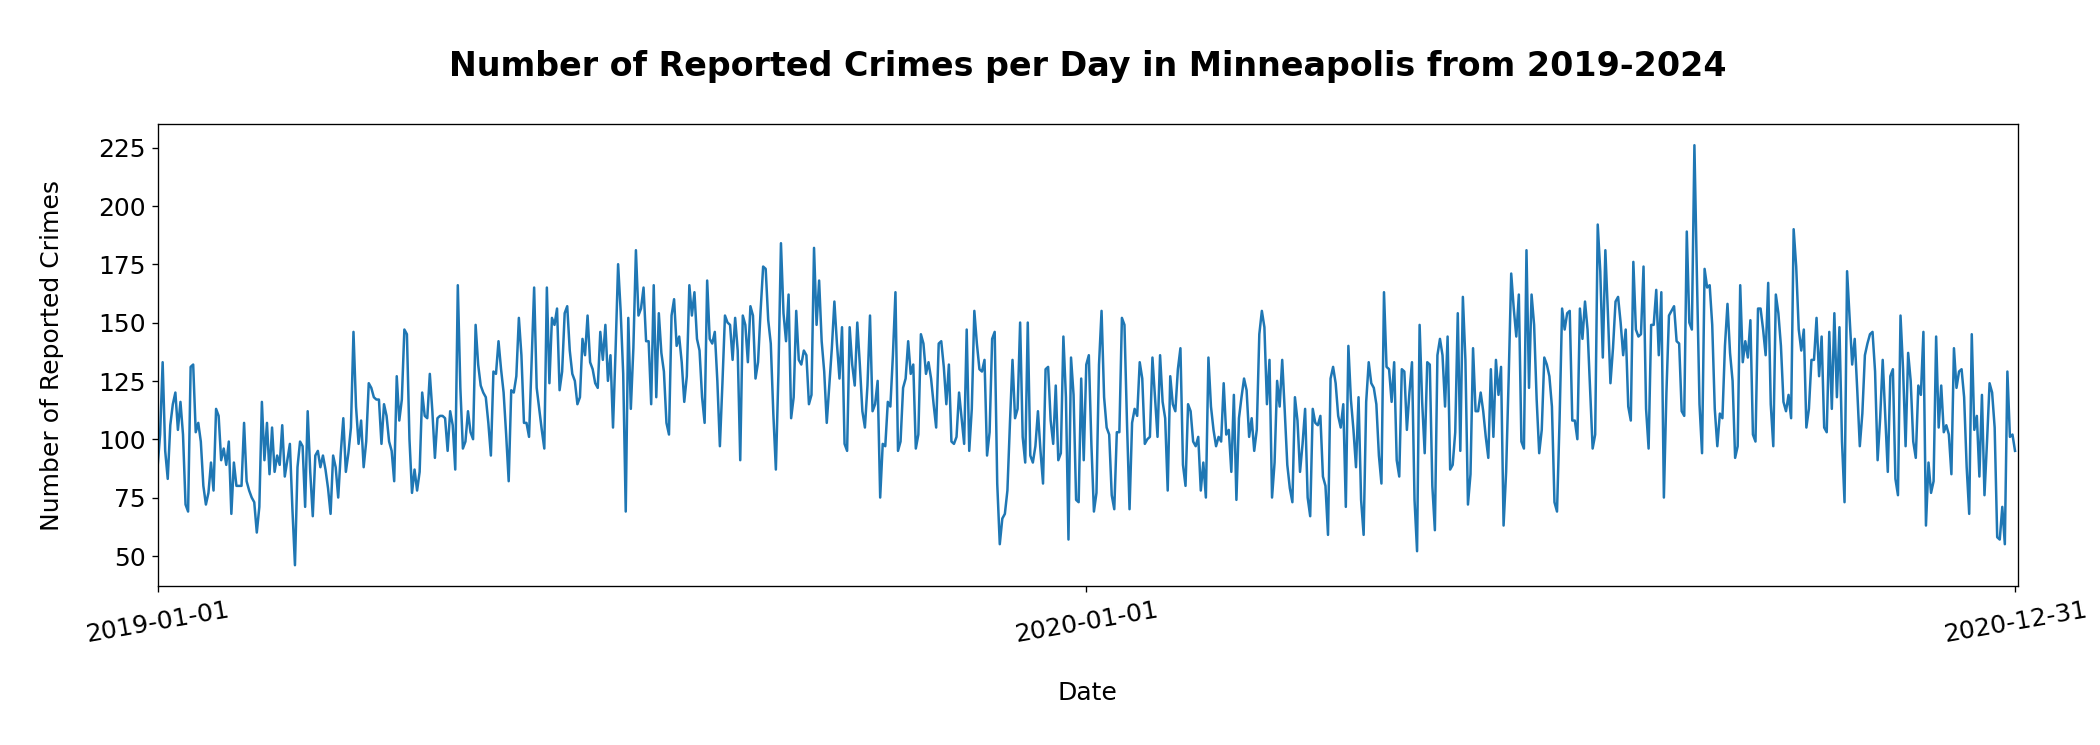

In [1116]:
#Look at plot
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train1.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



In [1117]:
#ADF Test

# Perform Augmented Dickey-Fuller test
result = adfuller(train1)

# Extract and print the test statistics and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: -1.5447958387885525
P-value: 0.5112466837476183


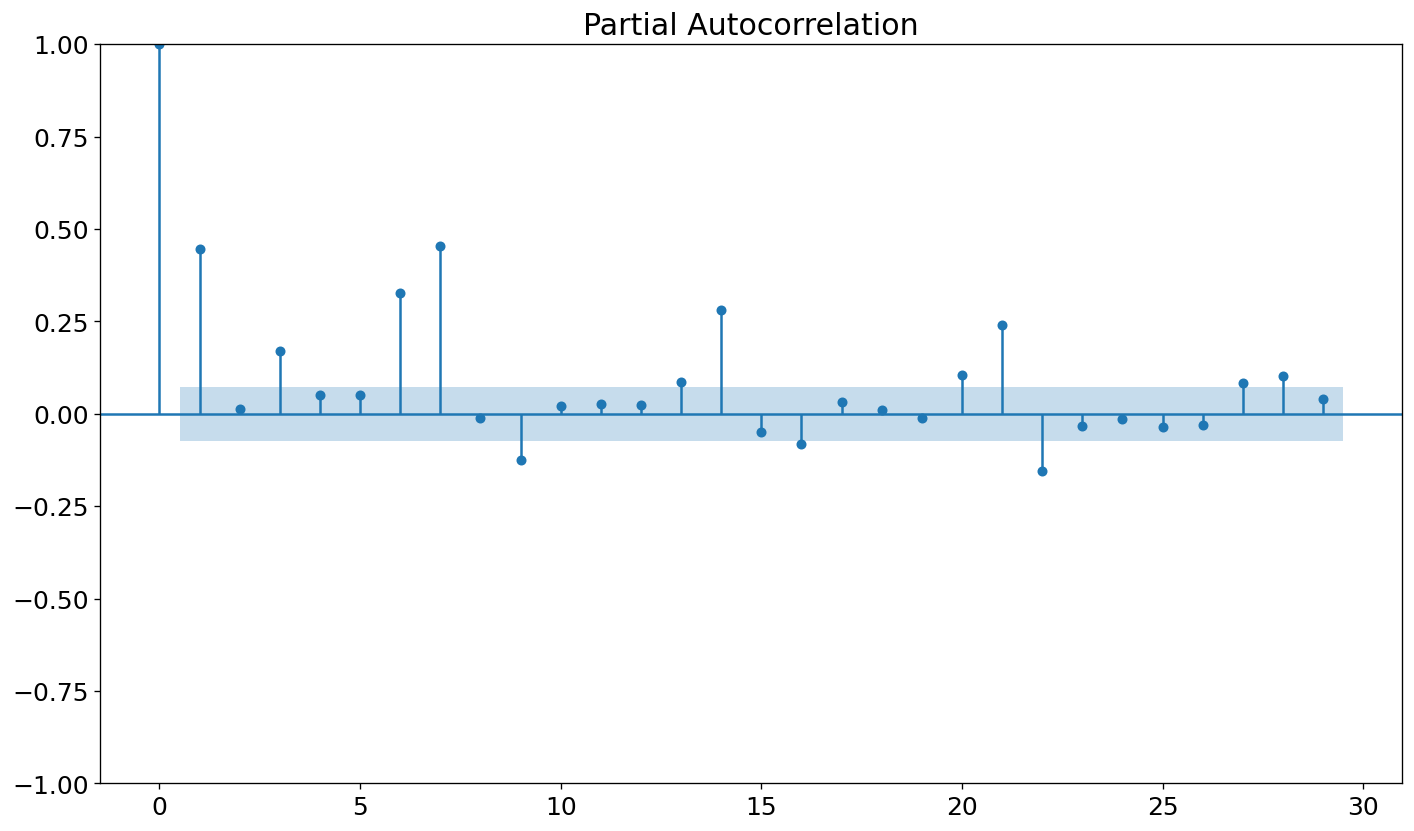

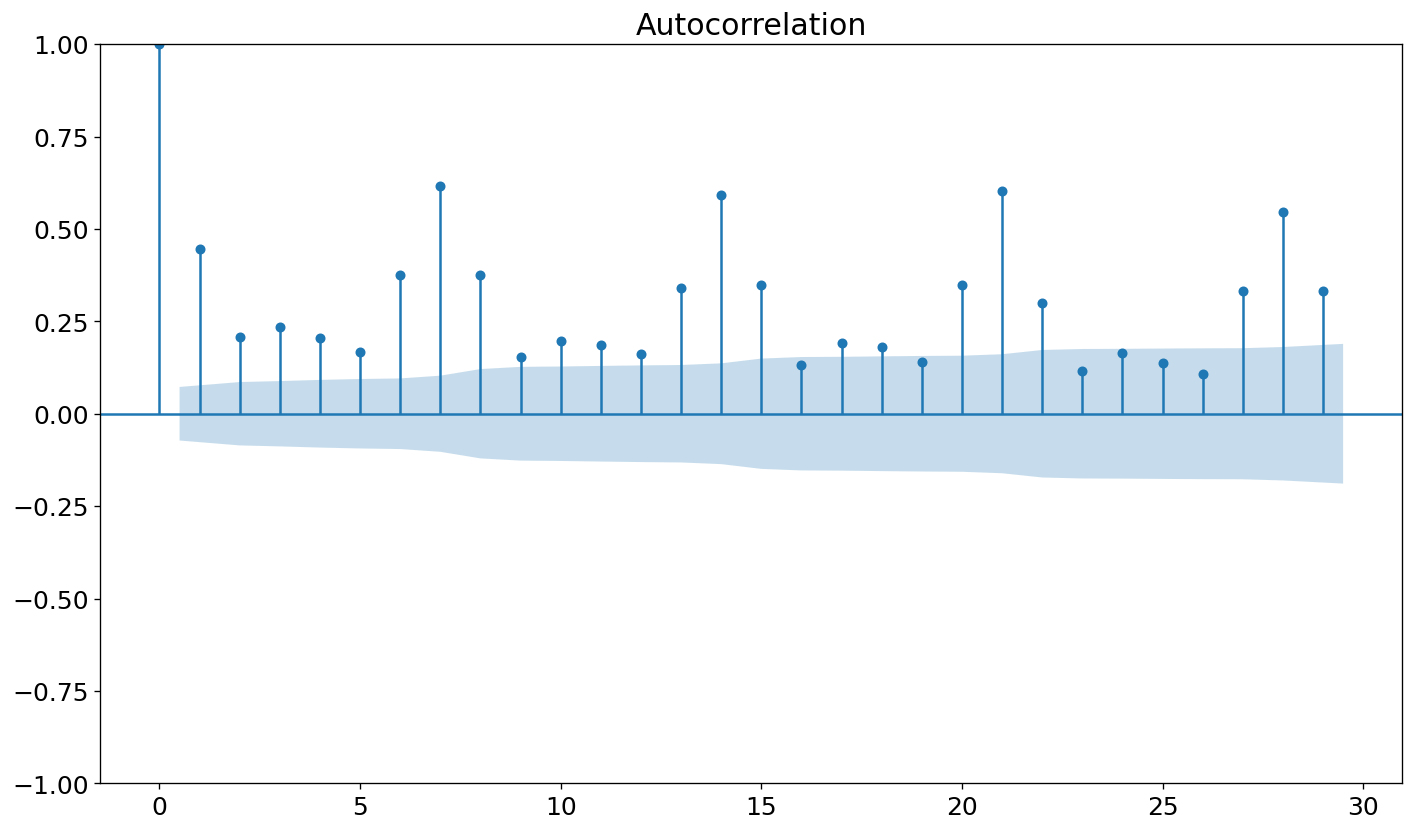

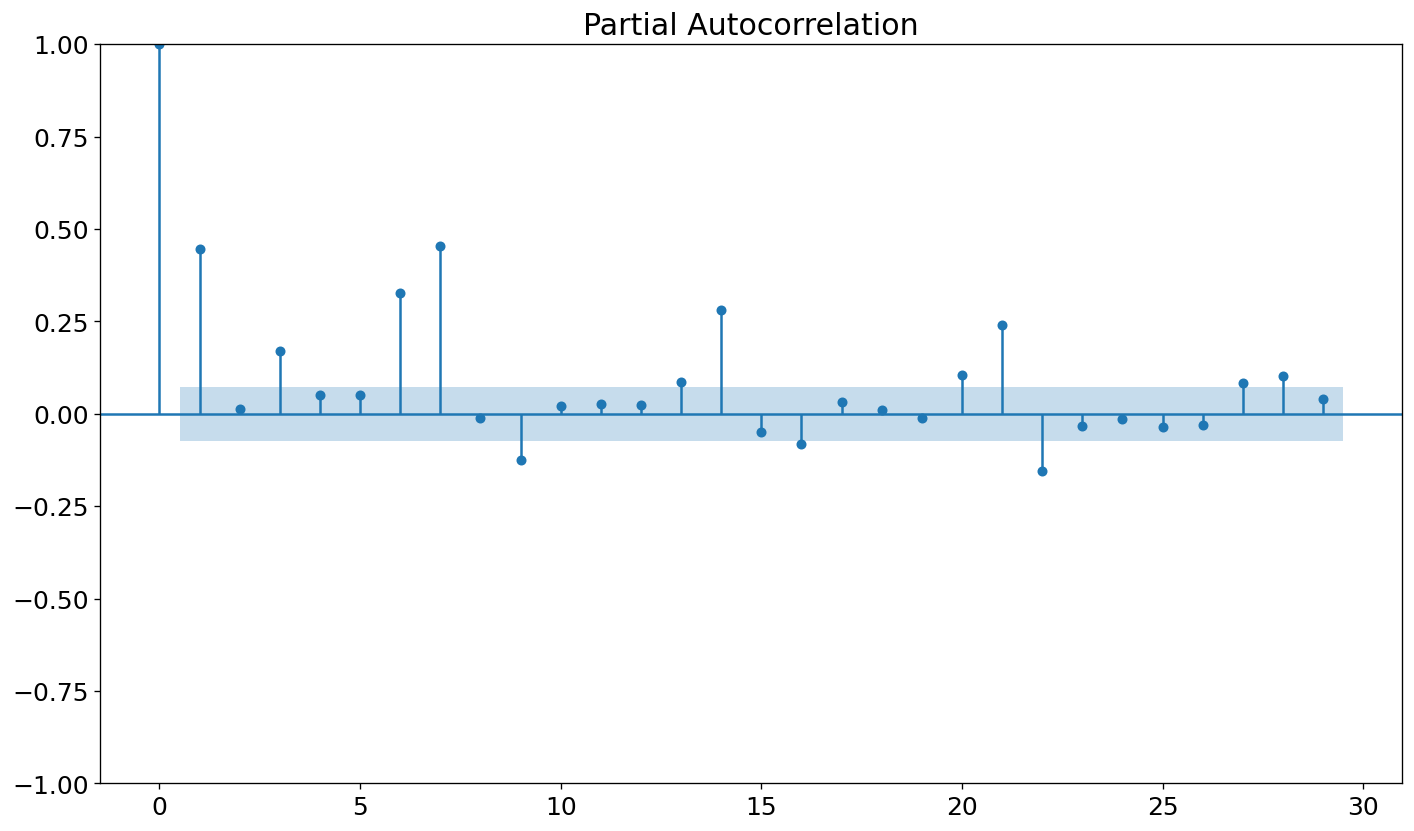

In [1118]:
#ACF
plot_acf(train1.Crime_Count.dropna())
#PACF
plot_pacf(train1.Crime_Count.dropna())

### Check for Seasonality

In [1119]:
train1['date']=train1.index
train1['date'] = pd.to_datetime(train1['date'], format='%Y-%m-%d')
train1

,Crime_Count,date
Date,,
2019-01-01,88,2019-01-01
2019-01-02,102,2019-01-02
2019-01-03,133,2019-01-03
2019-01-04,95,2019-01-04
2019-01-05,83,2019-01-05
...,...,...
2020-12-27,55,2020-12-27
2020-12-28,129,2020-12-28
2020-12-29,101,2020-12-29


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

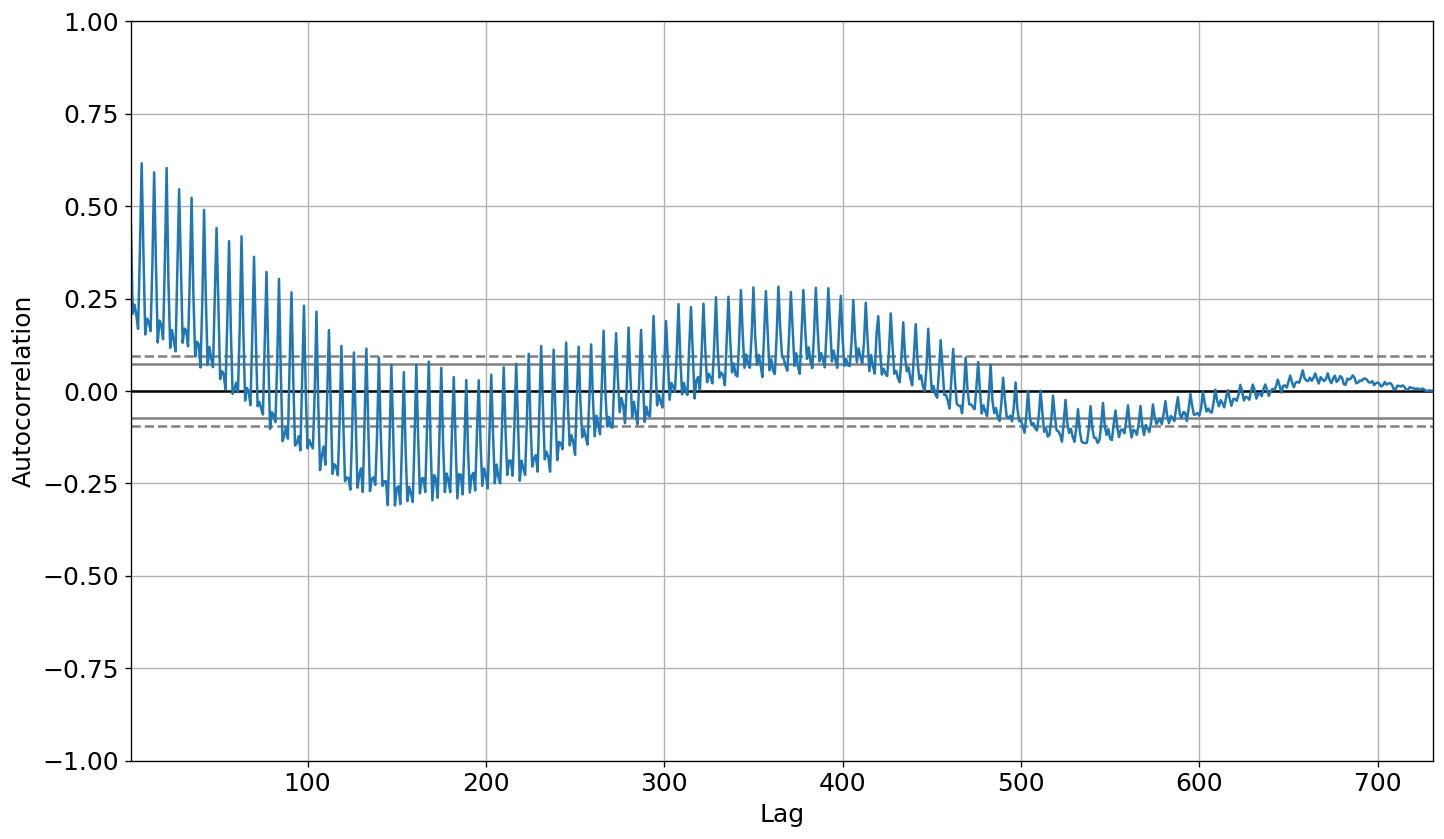

In [1120]:
#Autocorrelation
autocorrelation_plot(train1['Crime_Count'])

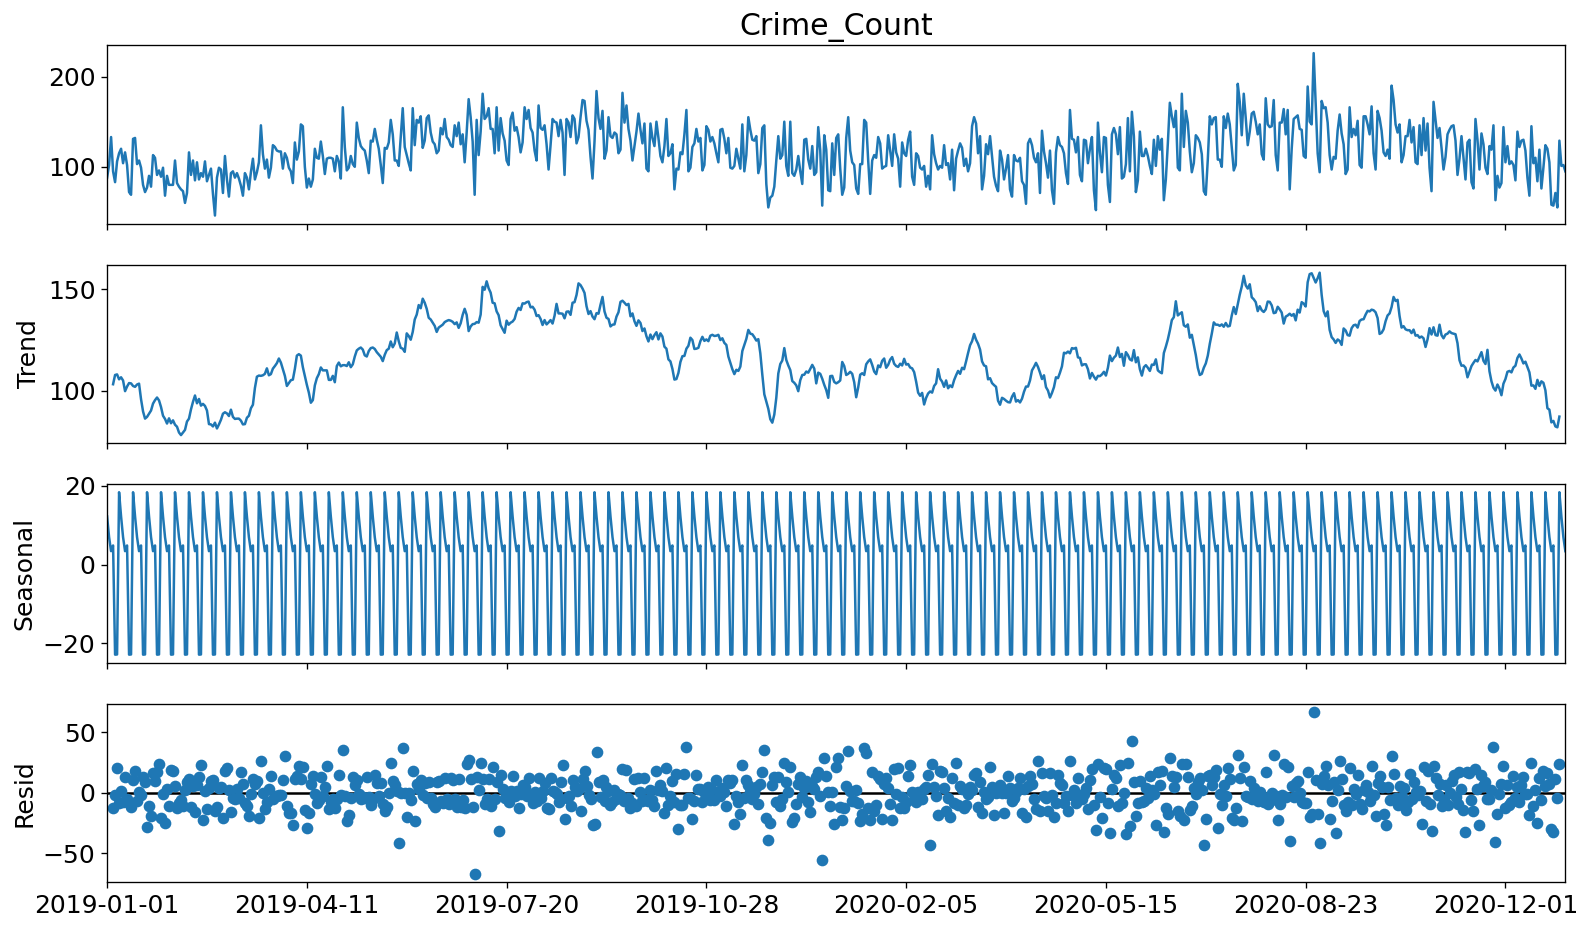

In [1121]:
decomposition=seasonal_decompose(train1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train1), 100))
plt.show()

### Seasonal Differencing

In [1122]:
train1s1= train1
train1s1['Crime_Count']=train1['Crime_Count'] - train1['Crime_Count'].shift(7)
train1s1=train1s1.dropna()
train1s1

,Crime_Count,date
Date,,
2019-01-08,32.0,2019-01-08
2019-01-09,2.0,2019-01-09
2019-01-10,-17.0,2019-01-10
2019-01-11,7.0,2019-01-11
2019-01-12,-11.0,2019-01-12
...,...,...
2020-12-27,-44.0,2020-12-27
2020-12-28,5.0,2020-12-28
2020-12-29,-19.0,2020-12-29


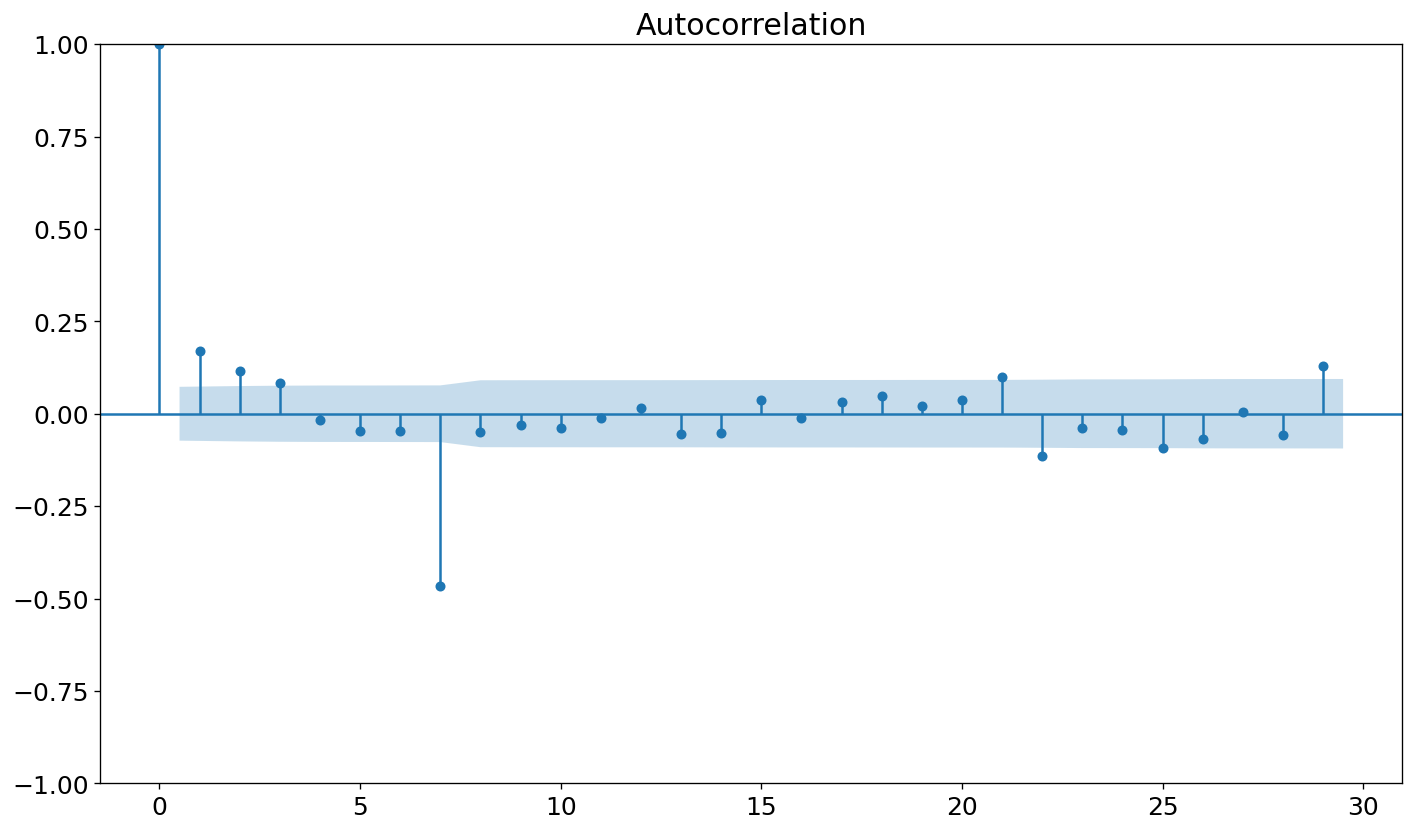

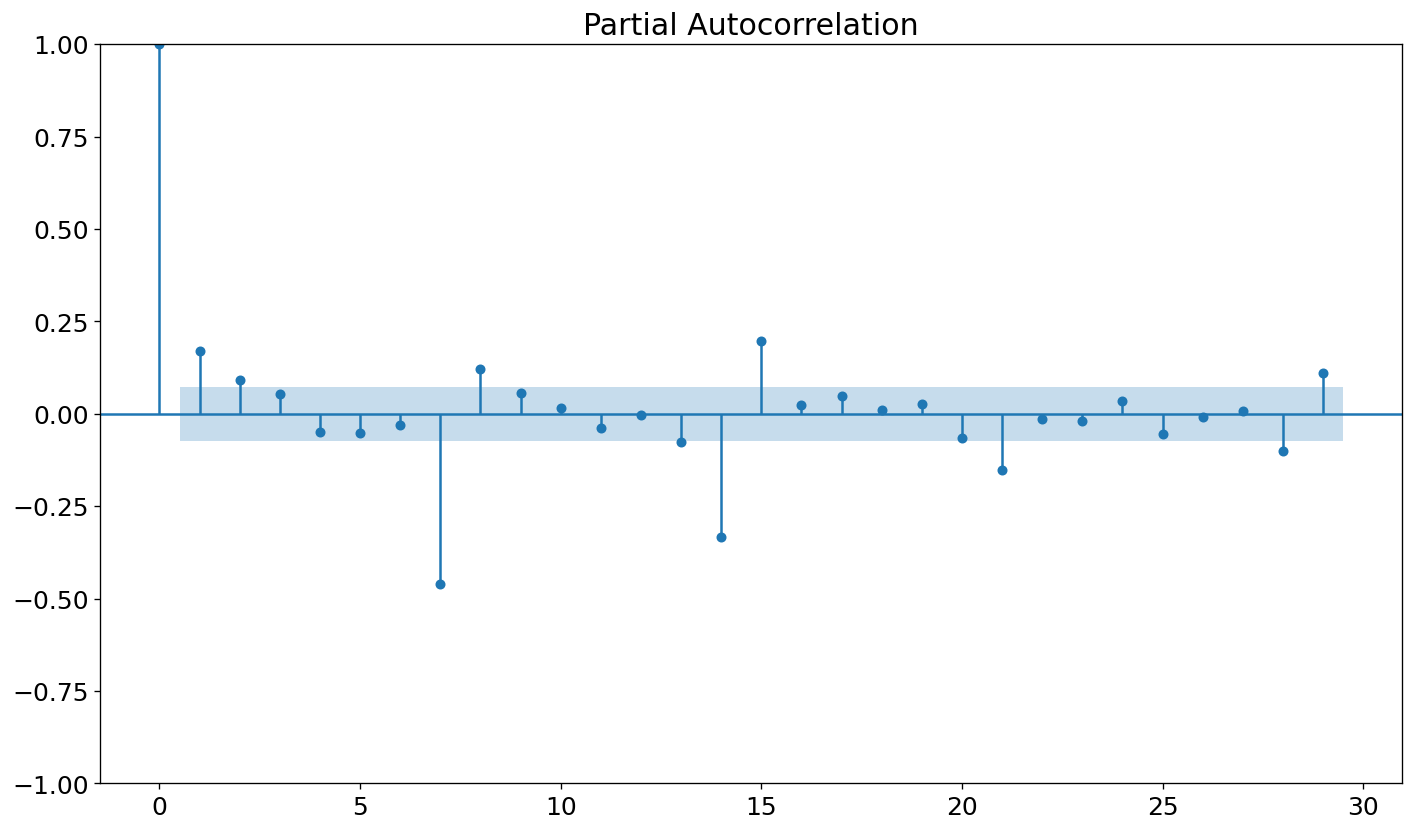

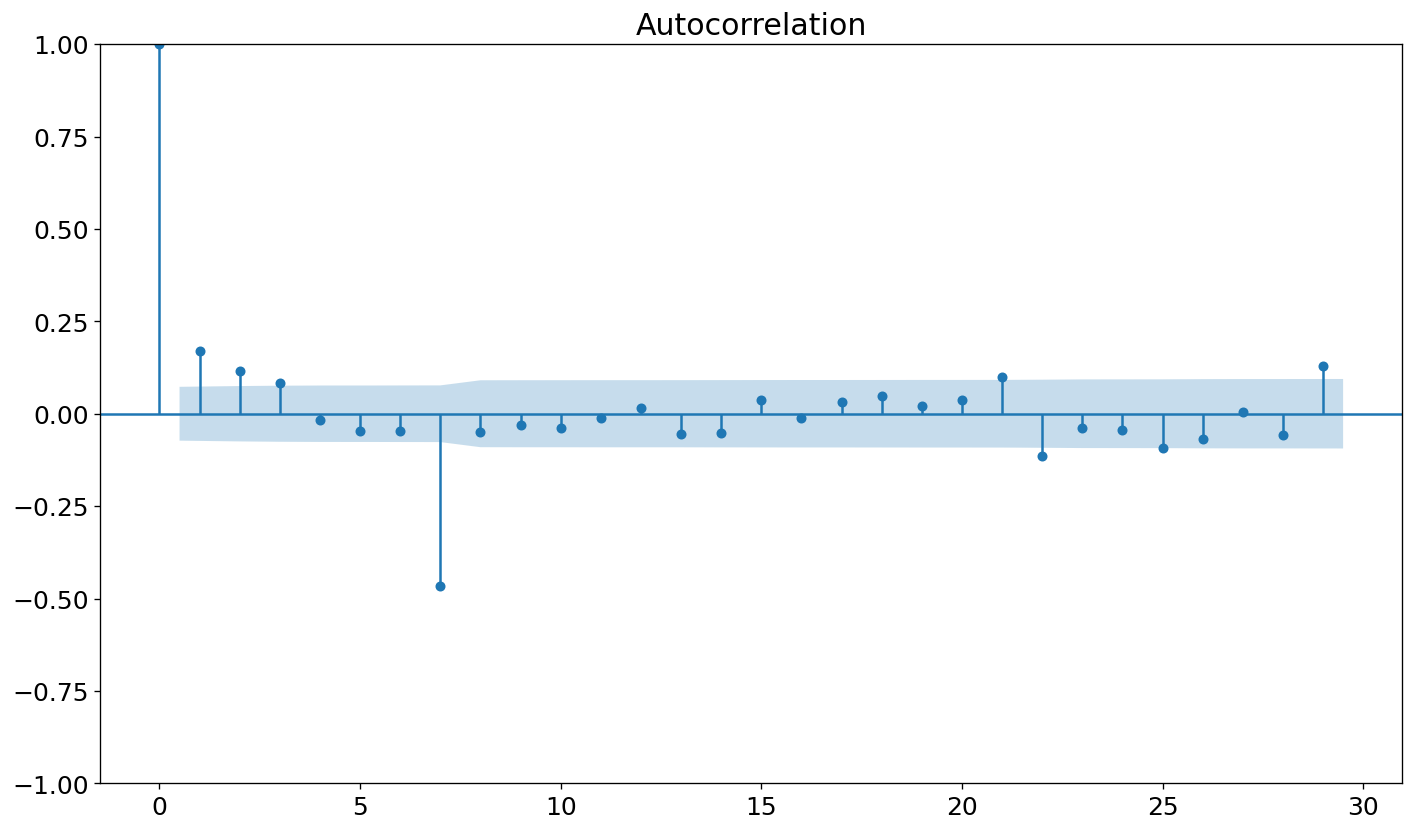

In [1123]:
plot_pacf(train1s1.Crime_Count)
plot_acf(train1s1.Crime_Count)

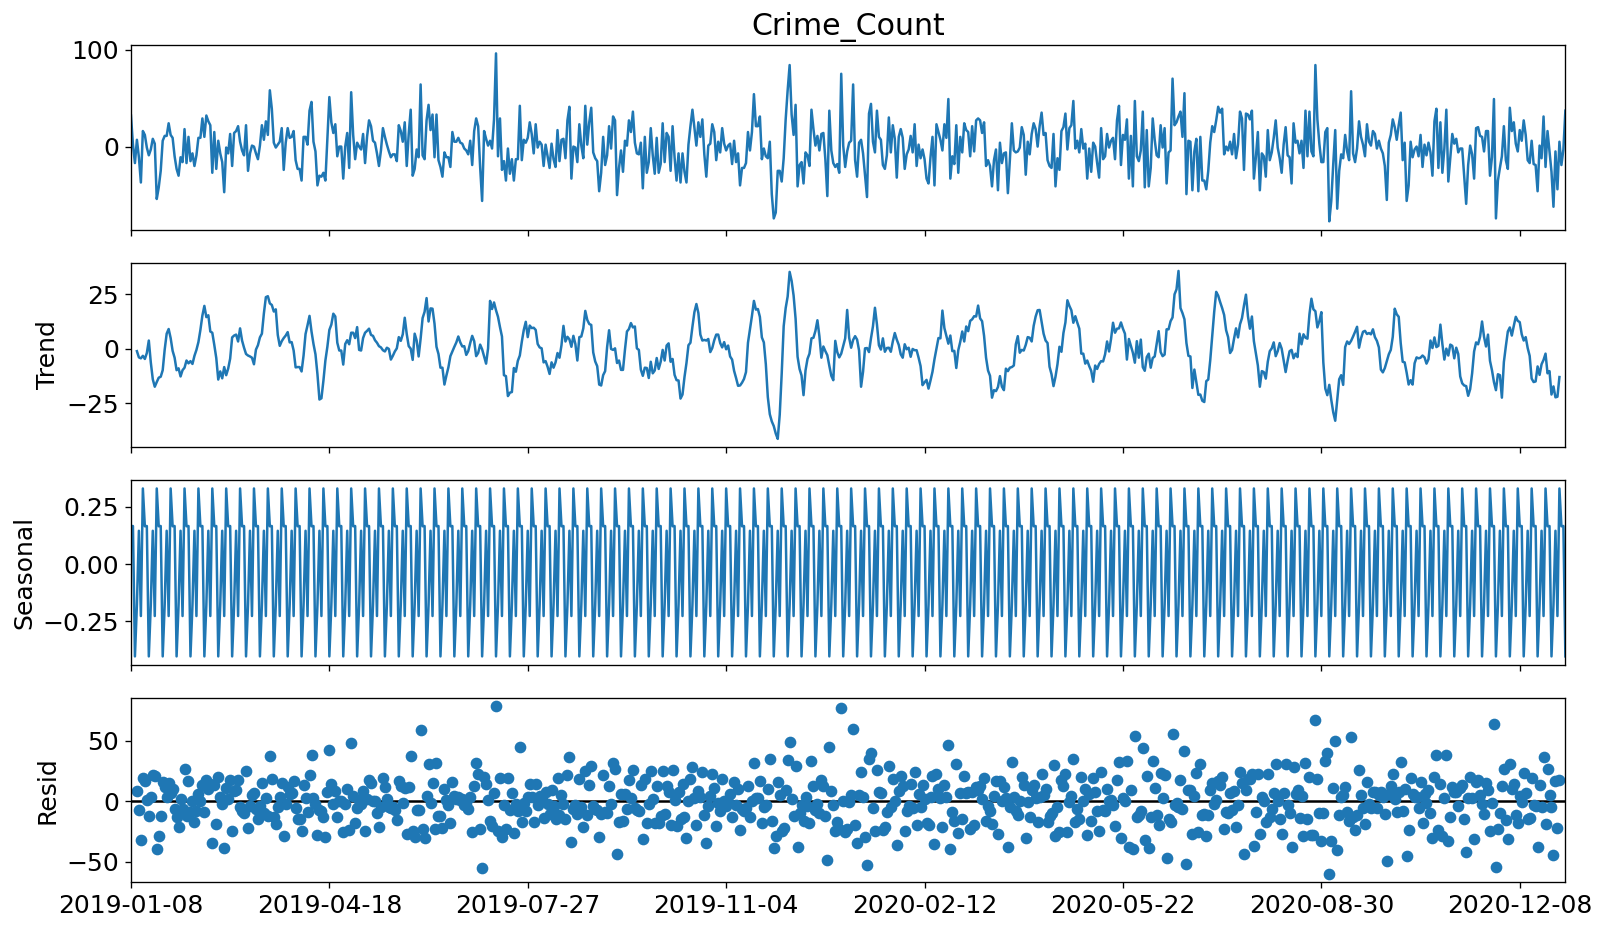

In [1124]:
# Trying Differencing of 7
decomposition=seasonal_decompose(train1s1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train1), 100))
plt.show()

In [1125]:
#ADF Test

# Perform Augmented Dickey-Fuller test
result = adfuller(train1s1['Crime_Count'])

# Extract and print the test statistics and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: -7.930811374734511
P-value: 3.5172964205452434e-12


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

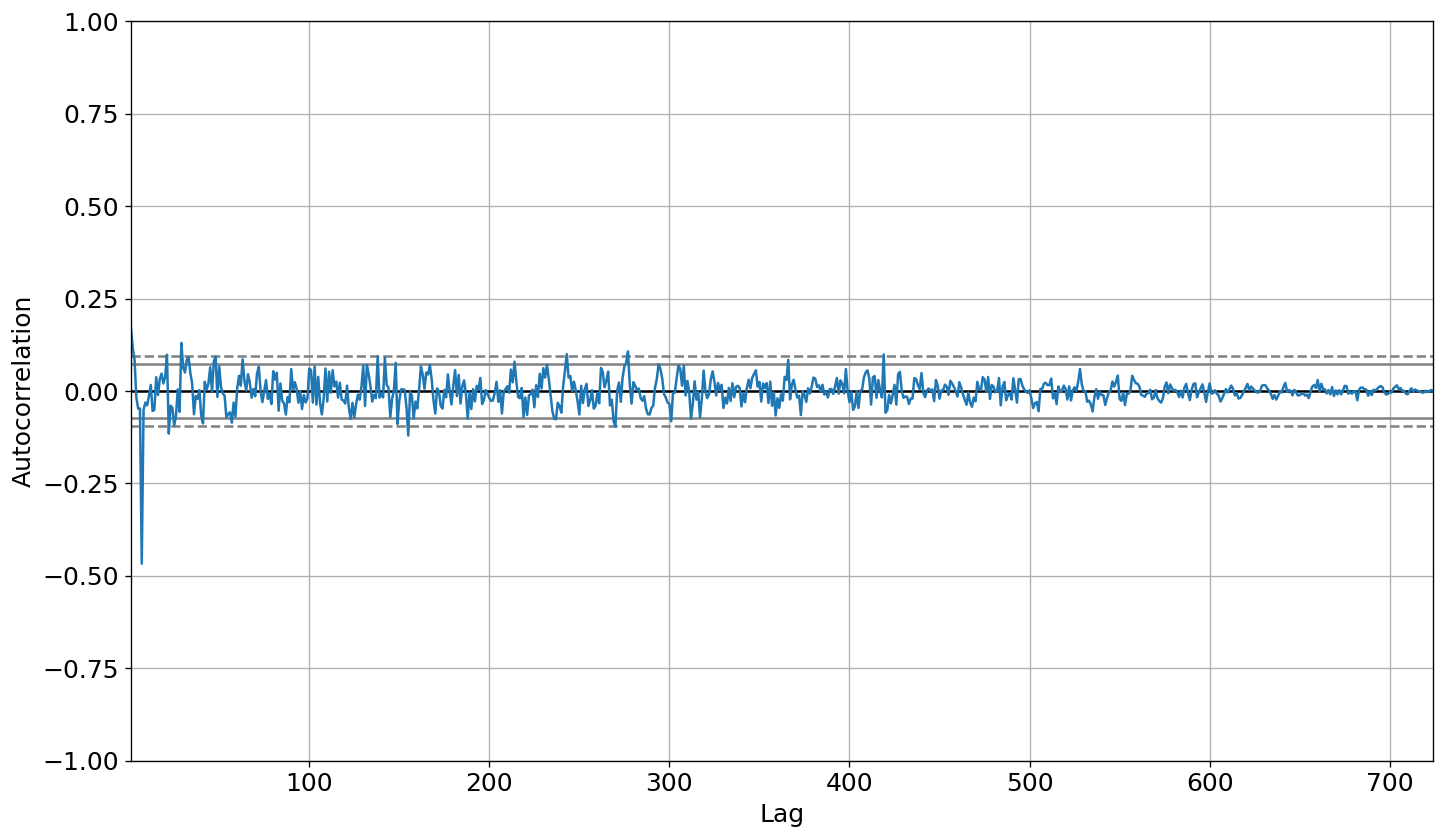

In [1126]:
autocorrelation_plot(train1s1['Crime_Count'])

### Determine parameters and Fit Model

In [1127]:
sarima = SARIMAX(train1s1['Crime_Count'], order=(1,1,1), seasonal_order=(1,7,0,7))
model_fit = sarima.fit(disp=False) 


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Calculate MAE RMSE MAPE MASE

In [1128]:
#Check Predictive Accuaracy

fcast_len = len(test1)
fcast = model_fit.forecast(fcast_len)

mse1 = mean_squared_error(test1, fcast)
rmse1 = np.sqrt(mse1)
mae1 = mean_absolute_error(test1, fcast)
mape1= mean_absolute_percentage_error(test1, fcast)

print(f'Mean Squared Error: {mse1}')
print(f'Root Mean Squared Error: {rmse1}')
print(f'Mean Absolute Error: {mae1}')
print(f'Mean Absolute Percentage Error: {mape1}')


# plt.figure(figsize=(20, 10))
# plt.title('Candy Production Forecast', fontsize=30)
# plt.plot(train, label='Train')
# plt.plot(fcast, label='Forecast')
# plt.plot(test, label='Test')
# plt.legend(fontsize=25)
# plt.show()

Mean Squared Error: 4.663713028457729e+20
Root Mean Squared Error: 21595631568.578236
Mean Absolute Error: 10395287428.715942
Mean Absolute Percentage Error: 96031024.79438479


### Model Diagnostics

In [1129]:
#Model Diagnostics

#INCOMPLETE

## Repeat FOR STEP 2: Set 2 2019-2022

Text(0, 0.5, '\nNumber of Reported Crimes\n')

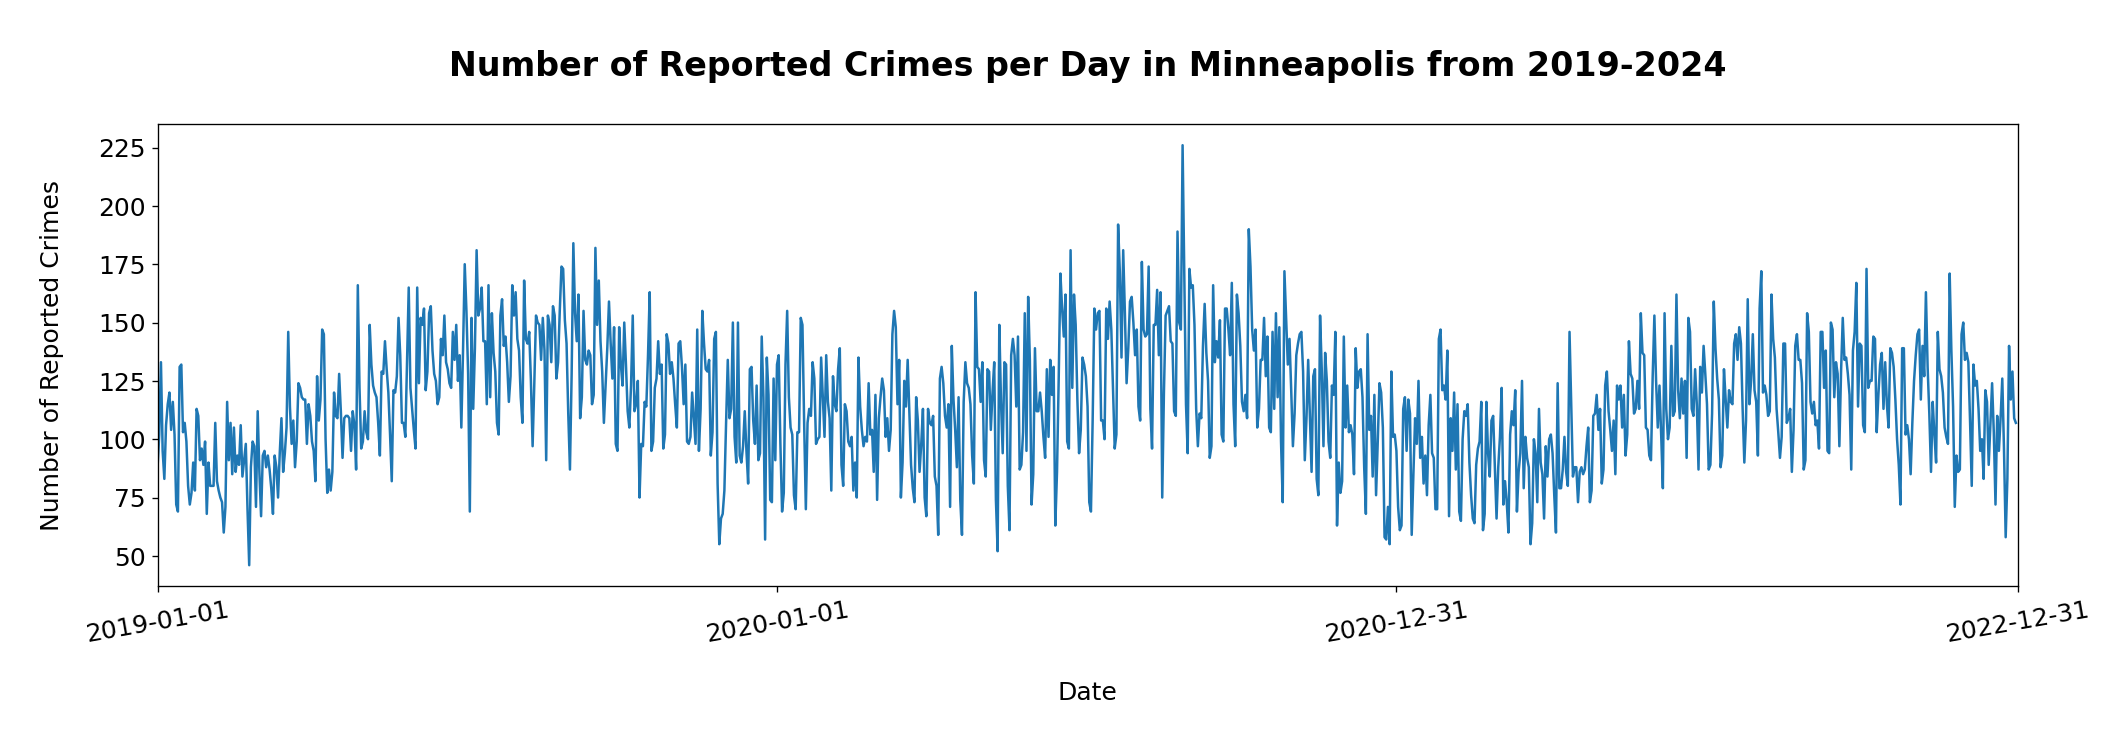

In [ ]:
# PLOT
ax.clear()
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train2.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2022-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})

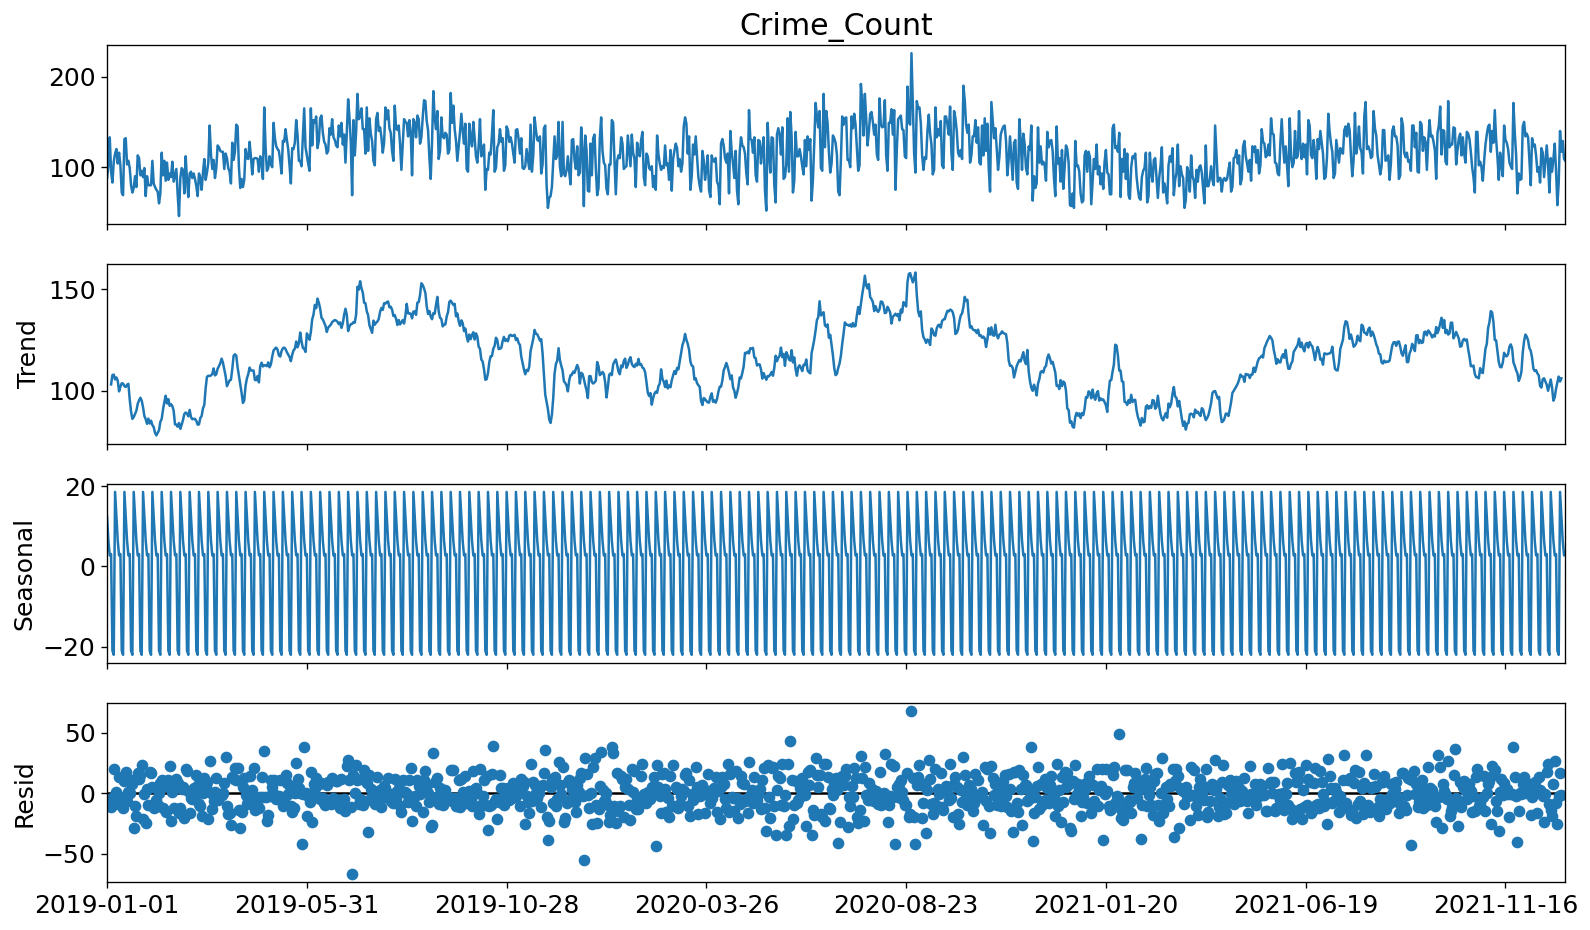

In [ ]:
#CHECK STATIONARITY and SEASONALITY
decomposition=seasonal_decompose(train2['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train2), 150))
plt.show()


In [1132]:
#CHECK SEASONALITY

In [1133]:
#DIFFERENCE

In [1134]:
#FIT MODEL AND CALCULATE MSE

## REAPEAT FOR STEP 3: Set 3 2019-2023

In [1135]:
# #PLOT
# fig, ax=plt.subplots(figsize=(20, 5))
# plt.plot(train_set.Crime_Count); 
# plt.xticks(rotation=10, fontsize=15)

# years = mdates.YearLocator()  
# ax.xaxis.set_major_locator(years)

# ax.set_xlim('2019-01-01', '2024-12-31')
# ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
# ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
# ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



In [1136]:
#CHECK STATIONARITY

In [1137]:
#CHECK SEASONALITY

In [1138]:
#DIFFERENCE

In [1139]:
#FIT MODEL AND CALCULATE MSE

## REAPEAT FOR STEP $: Set 3 2019-2024

In [1140]:
# #PLOT
# fig, ax=plt.subplots(figsize=(20, 5))
# plt.plot(train_set.Crime_Count); 
# plt.xticks(rotation=10, fontsize=15)

# years = mdates.YearLocator()  
# ax.xaxis.set_major_locator(years)

# ax.set_xlim('2019-01-01', '2024-12-31')
# ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
# ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
# ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



## COMPARE SARIMA MODELS

In [1141]:
#ARIMA Model

## COMPARE TO AUTO SARIMA

In [1142]:
#Auto ARIMA Model

## FORECAST ALL SARIMA, AUTO SARIMA FOR 2025

In [1143]:
#Forecast 2025
#RMSE	MAE	MAPE	MASE